## Overview

We'll fit a Gaussian process model $Z(\boldsymbol{s})$ of the form

\begin{align*}
\mathbb{E}\left\{Z(\boldsymbol{s})\right\} &= \beta_1\\
\mathrm{Cov}\left\{Z(\boldsymbol{s}), Z(\boldsymbol{u})\right\} &= 
    \sigma^2\left[\exp\left\{-\frac{1}{\theta}\left\|\boldsymbol{s}-\boldsymbol{u}\right\|\right\} + \eta\right]
\end{align*}

to a data set consisting of carbon-to-nitrogen ratios sampled across an agricultural field
after a tillage treatment.

The data is described in 

*Schabenberger Oliver, Pierce Fran.*
Contemporary Statistical Models for the
Plant and Soil Science. 11 2001. 738.

and analyzed in 

*Ren Cuirong, Sun Dongchu, He Chong.* Objective Bayesian analysis for a spatial
model with nugget effects // Journal of Statistical Planning and Inference.
2012. 142, 7. 1933–1946.

*De Oliveira Victor.* Objective Bayesian analysis of spatial data with measure-
ment error // Canadian Journal of Statistics. 06 2007. 35. 283 – 301.

## Load Data Set

In [1]:
import numpy as np
import time
import scipy
from bbai.gp import BayesianGaussianProcessRegression, Power1CovarianceFunction
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
from dataset.soil_cn.soil_cn_dataset import X, y
n = len(y)
Z = np.array(X)
X = np.ones((n, 1))

Text(0.5, 1.0, 'Sampling Locations')

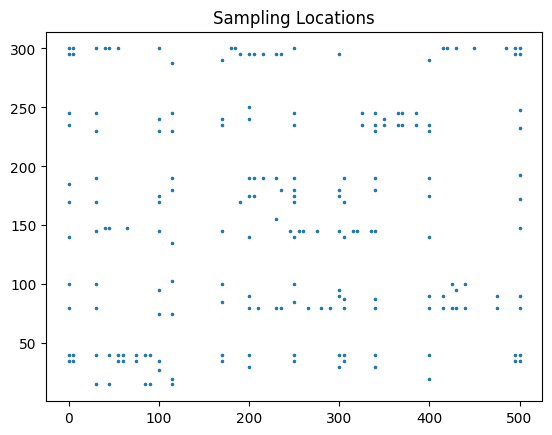

In [3]:
plt.scatter(Z[:, 0], Z[:, 1], s=2.5)
plt.title("Sampling Locations")

## Fit Model

In [4]:
model = BayesianGaussianProcessRegression(kernel=Power1CovarianceFunction(), tolerance=1.0e-4)
t1 = time.time()
model.fit(Z, y, X)
t2 = time.time()
print('Time to fit %f sec' % (t2 - t1))

Time to fit 2.680883 sec


## Plot Sparse Grid

Text(0, 0.5, 'Log Noise Ratio')

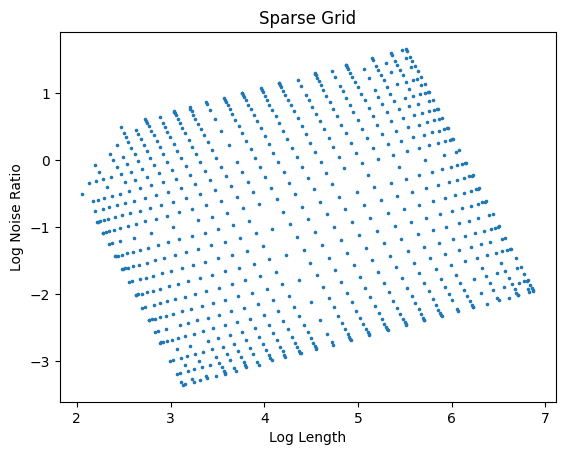

In [5]:
plt.scatter(model.hyperparameter_matrix_[0, :], model.hyperparameter_matrix_[1, :], s=2.5)
plt.title('Sparse Grid')
plt.xlabel('Log Length')
plt.ylabel('Log Noise Ratio')

## Plot Marginal Length

median length = 62.54595619234351


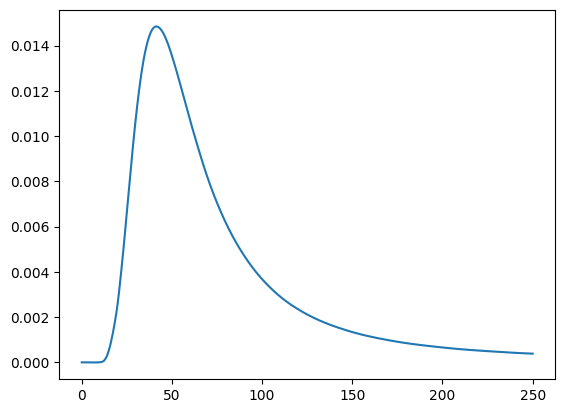

In [6]:
m = model.marginal_length_
lx = np.arange(0.1, 250, 0.01)
px = np.array([m.pdf(li) for li in lx])
plt.plot(lx, px)
print('median length =', m.ppf(0.5))

## Plot Marginal Noise Ratio

median noise ratio = 0.44278452724756057


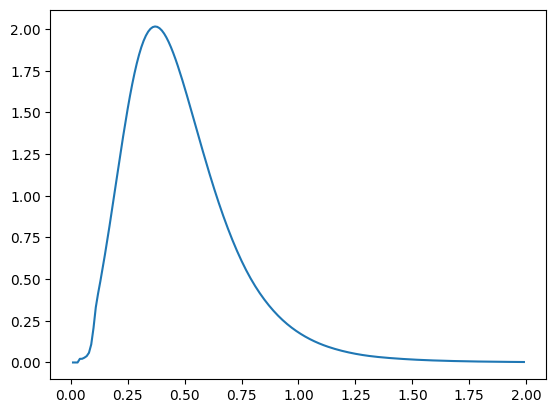

In [7]:
m = model.marginal_noise_ratio_
lx = np.arange(0.01, 2.0, 0.01)
px = np.array([m.pdf(li) for li in lx])
plt.plot(lx, px)
print('median noise ratio =', m.ppf(0.5))

## Plot Marginal of Sigma2 Signal

median sigma2-signal = 0.24538997805604332


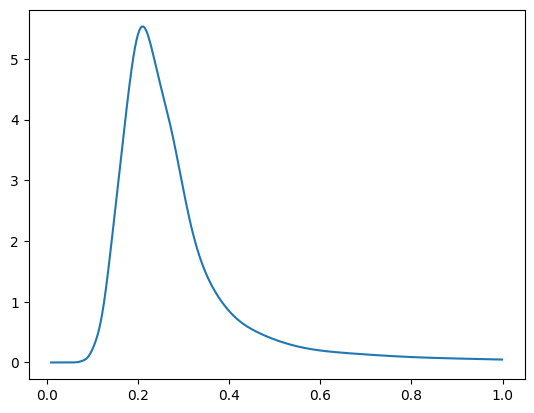

In [8]:
m = model.marginal_sigma2_signal_
lx = np.arange(0.01, 1.0, 0.001)
px = np.array([m.pdf(li) for li in lx])
plt.plot(lx, px)
print('median sigma2-signal =', m.ppf(0.5))

## Plot Marginal $\beta_1$

median beta_1 = 10.859737708557505


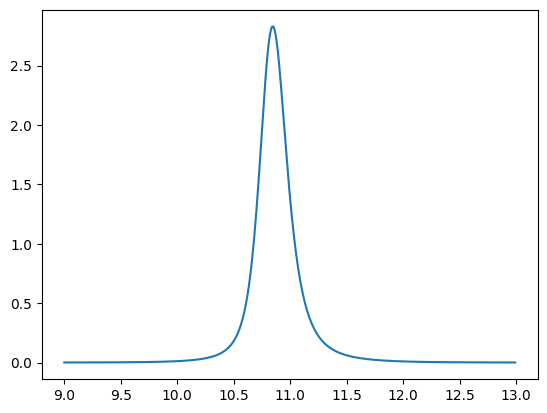

In [9]:
m = model.marginal_regressors_[0]
lx = np.arange(9.0, 13.0, 0.01)
px = np.array([m.pdf(li) for li in lx])
plt.plot(lx, px)
print('median beta_1 =', m.ppf(0.5))

## Plot Predictions

In [10]:
def f(XX, YY):
    n = XX.shape[0] * XX.shape[1]
    Zt = np.zeros((n, 2))
    Xt = np.ones((n, 1))
    index = 0
    for i in range(XX.shape[0]):
        for j in range(XX.shape[1]):
            Zt[index, 0] = XX[i, j]
            Zt[index, 1] = YY[i, j]
            index += 1
    pred = model.predict(Zt, Xt)
    index = 0
    res = np.zeros(XX.shape)
    for i in range(XX.shape[0]):
        for j in range(XX.shape[1]):
            res[i, j] = pred[index]
            index += 1
    return res

In [11]:
def f_err(XX, YY):
    n = XX.shape[0] * XX.shape[1]
    Zt = np.zeros((n, 2))
    Xt = np.ones((n, 1))
    index = 0
    for i in range(XX.shape[0]):
        for j in range(XX.shape[1]):
            Zt[index, 0] = XX[i, j]
            Zt[index, 1] = YY[i, j]
            index += 1
    _, pdfs = model.predict(Zt, Xt, with_pdf=True)
    index = 0
    res = np.zeros(XX.shape)
    for i in range(XX.shape[0]):
        for j in range(XX.shape[1]):
            pdf = pdfs[index]
            res[i, j] = pdf.ppf(0.75) - pdf.ppf(0.25)
            index += 1
    return res

In [12]:
xx = np.linspace(0, 500, 25)
yy = np.linspace(0, 300, 25)
XX, YY = np.meshgrid(xx, yy)
fxy = f(XX, YY)
fxy_err = f_err(XX, YY)

Text(0.5, 1.0, 'Predicted Mean C/N')

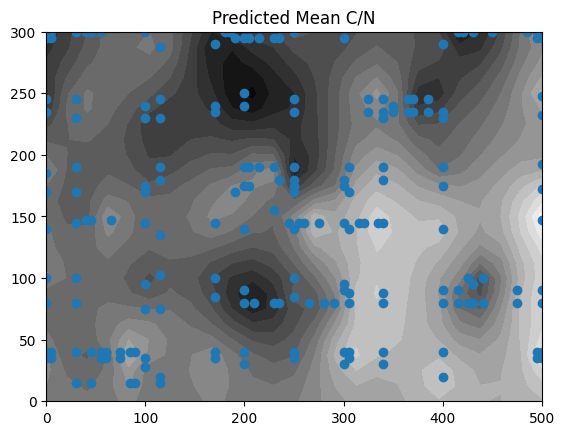

In [13]:
plt.contourf(XX, YY, fxy, 20, cmap=cm.gray)
plt.scatter(Z[:, 0], Z[:, 1])
plt.title("Predicted Mean C/N")

Text(0.5, 1.0, 'Prediction 25% - 75% Credible Set Length')

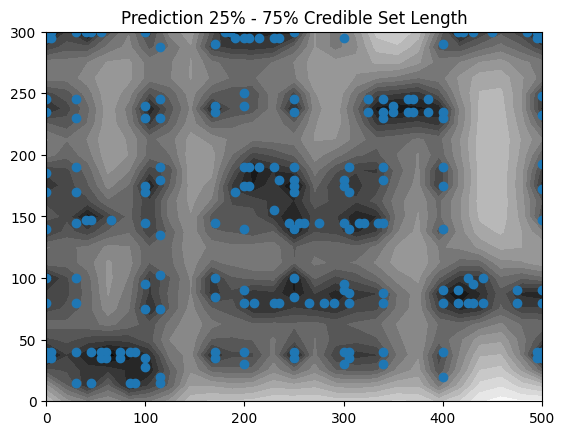

In [14]:
plt.contourf(XX, YY, fxy_err, 20, cmap=cm.gray)
plt.scatter(Z[:, 0], Z[:, 1])
plt.title("Prediction 25% - 75% Credible Set Length")